In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


from torchvision import datasets
from torchvision import transforms
import torch.optim as optim

import numpy as np
from scipy import linalg
import torchvision.models as models
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

Mounted at /content/drive


In [2]:
# Basic parameters

batch_size = 64
n_epochs = 25
img_size = 28
lr = 0.0002
lr_g = 0.0001
momentum = 0.5
beta1 = 0.5
beta2 = 0.999
n_classes = 10

nz_dims = 100
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

print(device)

cuda:0


In [3]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        print("Conv")
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        print("BN")
    else:
      print("None")

def save_image(b_size, epoch, generator):
  noise = torch.randn(b_size, nz_dims).to(device)

  #fixed labels
  y_ = torch.LongTensor(np.array([num for num in range(n_classes)])).view(n_classes,1).expand(-1,n_classes).contiguous()
  y_fixed = torch.zeros(n_classes**2, n_classes)
  y_fixed = y_fixed.scatter_(1,y_.view(n_classes**2,1),1).to(device)

  gen_imgs = generator(noise, y_fixed).view(-1,1,28,28)
  save_image(gen_imgs.data, img_save_path + '/%d-%d.png' % (n_epochs, epoch), nrow=n_classes, normalize=True)
  print("Image Saved")

In [4]:
# Load dataset

dataset = datasets.MNIST('data', train=True, download=True, transform=transforms.Compose([
                             transforms.Resize(28),
                             transforms.ToTensor(),
                             transforms.Normalize((0.5), (0.5))]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

real_batch = next(iter(dataloader))
print(real_batch[0].shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 402963036.05it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 110930122.55it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 158544998.89it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5248079.55it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

torch.Size([64, 1, 28, 28])


In [5]:
# InceptionV3 Model for FID Score

class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp

  
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:03<00:00, 27.3MB/s]


In [6]:
# FID Calculation

def calculate_activation_statistics(images, model, batch_size=batch_size, dims=2048):
    model.eval()
    act=np.empty((len(images), dims))
    
    batch = images.to(device)
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = F.adaptive_avg_pool2d(pred, output_size=(1, 1))

    act = pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError('Imaginary component {}'.format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean)


def calc_fid(real, fake, model):
    fake = torch.reshape(fake, (64, 1, 28, 28))
    fake = fake.repeat(1, 3, 1, 1)
    real = real.repeat(1, 3, 1, 1)

    mu_1, std_1 = calculate_activation_statistics(real, model)
    mu_2, std_2 = calculate_activation_statistics(fake, model)
  
    fid_val = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
    return fid_val

In [7]:
# Discriminator model

class Discriminator(nn.Module):
    def __init__(self):
      super(Discriminator, self).__init__()
      self.fc1_x = nn.Linear(in_features=784, out_features=1024)  
      self.fc1_y = nn.Linear(in_features=10, out_features=1024)

      # Concatenated
      self.fc2 = nn.Linear(in_features=2048, out_features=1024)
      self.fc2_bn = nn.BatchNorm1d(1024)
      self.fc3 = nn.Linear(in_features=1024, out_features=256)
      self.fc3_bn = nn.BatchNorm1d(256)
      self.fc5 = nn.Linear(in_features=256, out_features=64)
      self.fc5_bn = nn.BatchNorm1d(64)
      self.fc6 = nn.Linear(in_features=64, out_features=1)
      self.drop = nn.Dropout(0.5)

    def forward(self, x, cond):
      x = x.view(-1, 784)
      x = F.relu(self.fc1_x(x))
      cond = F.relu(self.fc1_y(cond))
      x = torch.cat([x, cond], 1)

      x = F.relu(self.fc2_bn(self.fc2(x)))
      x = self.drop(x)
      x = F.relu(self.fc3_bn(self.fc3(x)))
      x = self.drop(x)
      x = F.relu(self.fc5_bn(self.fc5(x)))
      x = self.drop(x)
      x = self.fc6(x)
      x = F.sigmoid(x)
      return x

In [8]:
# Generator model

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.fc1_noise = nn.Linear(in_features=100, out_features=256)  
      self.fc1_noise_bn = nn.BatchNorm1d(256)
      self.fc1_y = nn.Linear(in_features=10, out_features=256)
      self.fc1_y_bn = nn.BatchNorm1d(256)

      # Combined
      self.fc2 = nn.Linear(in_features=512, out_features=512)
      self.fc2_bn = nn.BatchNorm1d(512)
      self.fc3 = nn.Linear(in_features=512, out_features=1024)
      self.fc3_bn = nn.BatchNorm1d(1024)
      self.fc5 = nn.Linear(in_features=1024, out_features=784)
      self.drop = nn.Dropout(0.5)
     
    
    def forward(self, noise, cond):
      noise = F.relu(self.fc1_noise_bn(self.fc1_noise(noise)))   
      cond = F.relu(self.fc1_y_bn(self.fc1_y(cond)))

      x = torch.cat([noise, cond], 1)
      x = self.drop(x)
      x = F.relu(self.fc2_bn(self.fc2(x)))
      x = self.drop(x)
      x = F.relu(self.fc3_bn(self.fc3(x)))
      x = self.drop(x)
      x = F.relu(self.fc5(x))
      x = F.sigmoid(x)
      return x

In [9]:
# Training setup

netD = Discriminator()
netD = netD.to(device)
netD.apply(weights_init)

netG = Generator()
netG = netG.to(device)
netG.apply(weights_init)

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr_g)

loss_fn = nn.BCELoss()

real_val = 1.0
fake_val = 0.0

None
None
None
BN
None
BN
None
BN
None
None
None
None
BN
None
BN
None
BN
None
BN
None
None
None


In [10]:
D_losses = []
G_losses = []
b_size = 0

for epoch in range(n_epochs):
  for i, data in enumerate(dataloader):
    
    imgs = data[0].to(device)
    b_size = data[0].shape[0]

    labels = data[1]
    labels = F.one_hot(labels, num_classes=10)
    labels = labels.type(torch.FloatTensor)
    labels = labels.to(device)

    fake_labels = (torch.rand(b_size, 1) * 10).type(torch.LongTensor)
    fake_labels = fake_labels.view(-1)
    fake_labels = F.one_hot(fake_labels, num_classes=10)
    fake_labels = fake_labels.type(torch.FloatTensor)
    fake_labels = fake_labels.to(device)
    
    real_labels_1Hot = torch.full((b_size,), real_val, device=device)
    fake_labels_1Hot = torch.full((b_size,), fake_val, device=device)

    # -----------------
    #  Train Discriminator
    # -----------------
    # Real
    optimizerD.zero_grad()

    out_real = netD(imgs, labels)
    d_loss_real = loss_fn(out_real.squeeze(), real_labels_1Hot)
    d_loss_real.backward()


    # Fake
    noise = torch.randn(b_size, nz_dims).to(device)
    gen_fake = netG(noise, fake_labels)

    out_fake = netD(gen_fake.detach(), fake_labels)
    d_loss_fake = loss_fn(out_fake.squeeze(), fake_labels_1Hot)
    d_loss_fake.backward()

    d_loss = d_loss_real + d_loss_fake
    optimizerD.step()


    # -----------------
    #  Train Generator
    # -----------------
    optimizerG.zero_grad()
    out_fake = netD(gen_fake, fake_labels)
    g_loss = loss_fn(out_fake.squeeze(), real_labels_1Hot)

    g_loss.backward()
    optimizerG.step()
    

    # Print
    if i % 200 == 0:
      print('[Epoch %d/%d] [Batch %d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, n_epochs, i, len(dataloader), d_loss.item(), g_loss.item()))  

  # Each epoch
  D_losses.append(d_loss.item())
  G_losses.append(g_loss.item())

  fid = calc_fid(imgs, gen_fake, model)

  print('[Epoch %d/%d]\tAvg Loss_D: %.4f\tAvg Loss_G: %.4f\tFID: %.4f\n' % (epoch, n_epochs, sum(D_losses)/(epoch+1), sum(G_losses)/(epoch+1), fid))  

[Epoch 0/25] [Batch 0/937]	Loss_D: 1.4509	Loss_G: 0.8286
[Epoch 0/25] [Batch 200/937]	Loss_D: 1.3107	Loss_G: 0.7684
[Epoch 0/25] [Batch 400/937]	Loss_D: 1.2309	Loss_G: 0.8542
[Epoch 0/25] [Batch 600/937]	Loss_D: 1.1082	Loss_G: 1.0258
[Epoch 0/25] [Batch 800/937]	Loss_D: 0.8746	Loss_G: 1.2126
[Epoch 0/25]	Avg Loss_D: 0.9814	Avg Loss_G: 1.2132	FID: 330.1214

[Epoch 1/25] [Batch 0/937]	Loss_D: 0.7518	Loss_G: 1.2867
[Epoch 1/25] [Batch 200/937]	Loss_D: 0.7214	Loss_G: 1.3016
[Epoch 1/25] [Batch 400/937]	Loss_D: 0.4473	Loss_G: 1.8726
[Epoch 1/25] [Batch 600/937]	Loss_D: 0.4661	Loss_G: 2.0426
[Epoch 1/25] [Batch 800/937]	Loss_D: 0.2965	Loss_G: 2.4721
[Epoch 1/25]	Avg Loss_D: 0.6401	Avg Loss_G: 1.9212	FID: 381.4102

[Epoch 2/25] [Batch 0/937]	Loss_D: 0.2429	Loss_G: 2.6083
[Epoch 2/25] [Batch 200/937]	Loss_D: 0.3292	Loss_G: 2.7042
[Epoch 2/25] [Batch 400/937]	Loss_D: 0.1602	Loss_G: 3.0799
[Epoch 2/25] [Batch 600/937]	Loss_D: 0.1635	Loss_G: 3.5324
[Epoch 2/25] [Batch 800/937]	Loss_D: 0.1577	Loss

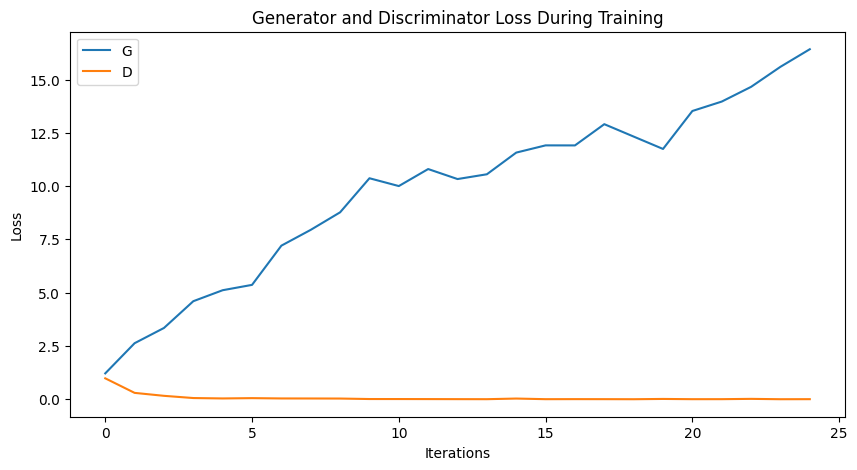

In [11]:
# Plot loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()